In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score as roc_auc_score
import matplotlib as mpl
import sys
import os
from pathlib import Path

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [21]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

$
\begin{aligned}
& \frac{1}{T}\sum_{t, l} w_{t,l} A(c|\alpha_{t,l}) B_1(x_1|\beta_{t,l}) B_2(x_2|\gamma_{t,l}) \\
\end{aligned}
$

In [22]:
def process_data(file, y_labels, x_labels, test=False):
    # Read data
    data = h5py.File(file, "r")
    df = pd.DataFrame(columns = x_labels)

    for i in range(len(x_labels)):
        df[x_labels[i]] = np.array(data["data"][:, i]).flatten()
   
    if ("x1" in x_labels):
        df = cartesian_to_polar_df(df, "x1", "x2", "r", "a1")

    elif ("r" in x_labels):
        df = polar_to_cartesian_df(df, "x1", "x2", "r", "a1")

    #df["Confidence"] = data["confidence"]
    for i in range(len(y_labels)):
        df[f"Std_samples_{y_labels[i]}"] = np.std(np.array(data["samples"][:, :, i]), axis=-1)
    
    # Get truth label values (annoying because text is not read as text, should fix)
    # Is fixed, just update
    if (test == False):
        df["class"] = data["truth"]
        df["Truth_label"] = y_labels[0]
        blue = 1.0
        df_copy = df.copy()
        mask = df_copy["class"] == blue
        df.loc[mask, "Truth_label"] = y_labels[1]
    
    # Get estimated probabilities
    for i in range(len(y_labels)):
        df[y_labels[i]] = data["probabilities"][:,i]
        df[f"Est_prob_{y_labels[i]}"] = data["probabilities"][:,i]

    # Get 25-75% error bars
    for i in range(len(y_labels)):
        df[f"quantile25_{y_labels[i]}"] = data["quantiles"][:, 1, i]
        df[f"quantile75_{y_labels[i]}"] = data["quantiles"][:, 2, i]
        df[f"Error_{y_labels[i]}"] = (df[f"quantile75_{y_labels[i]}"] - df[f"quantile25_{y_labels[i]}"])/2

    # Could be some NaNs
    len_nan = len(df[df.isnull().any(axis=1)])
    if len_nan > 0:
        print(f"Dropping {len_nan} rows of NaNs")
        df = df.dropna()

    # Get inferred color
    df["Inferred_color"] = df[[y_labels[0], y_labels[1]]].idxmax(axis=1)
    df["Inferred_class"] = 0 # red
    df_copy = df.copy()
    mask = df_copy["Inferred_color"] == "blue"
    df.loc[mask, "Inferred_class"] = 1

    
    return df

In [23]:
# Custom plot function
def plot_distributions(df):

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8), layout="constrained")

    # Plot 2D data points
    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.1, ax=axs[0][0])
    df_blue = df[df["color"] == "blue"]
    sn.scatterplot(df_blue, x="x1", y = "x2", c="blue", alpha=0.1, ax=axs[1][0])
    axs[0][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[0][0].set_ylim(min(df["x2"]), max(df["x2"]))
    axs[1][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[1][0].set_ylim(min(df["x2"]), max(df["x2"]))
    
    # Plot angular distribution
    sn.histplot(df_red, x="a_x", color="red", ax=axs[0][1])
    sn.histplot(df_blue, x="a_x", color="blue", ax=axs[1][1])
    axs[0][2].set_xlabel(r"$\theta_x$")
    axs[1][2].set_xlabel(r"$\theta_x$")

    # Plot radial distribution
    sn.histplot(df_red, x="r_x", color="red", ax=axs[0][2])
    sn.histplot(df_blue, x="r_x", color="blue", ax=axs[1][2])
    axs[0][2].set_xlabel(r"$|\vec{x}|$")
    axs[1][2].set_xlabel(r"$|\vec{x}|$")
    axs[0][2].set_xlim(0, 25)
    axs[1][2].set_xlim(0, 25)

    # Ticks
    for ax in axs.flatten():
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()

    return fig, ax

### Setup and constants

In [24]:
# Setup

#MCMC constants
n_samples = 1200
#n_data = [250, 5000]

#n_data = [25, 50, 250, 500, 1000, 2000, 3000, 5000, 10000]
n_data = [250, 500, 1000, 2000, 3000, 5000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
n_chains = [10, 10, 10, 10, 10, 10]
n_plots = len(n_data)

#Data constants
shapes = [2, 4]#[2, 2]
scales = [3, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

# Data labels
polar = False
y_labels = ["red", "blue"]
if polar:
    x_labels = ["r", "a1"]
else:
    x_labels = ["x1", "x2"]

# Read files
folderpath = "inference"
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"

if polar:
    analysis_folders = [f"{trainfile}/nsamples-{n_samples}_nchains-{n_chains[i]}_ndata-{n_data[i]}_POLAR" for i in range(n_plots)]
else:
    analysis_folders = [f"{trainfile}/nsamples-{n_samples}_nchains-{n_chains[i]}_ndata-{n_data[i]}" for i in range(n_plots)]
#valfiles = [f"{folderpath}/{folder}/{valfile}_inferred.h5" for folder in analysis_folders]
testfiles = [f"{folderpath}/{folder}/{testfile}_inferred.h5" for folder in analysis_folders]
gridfiles = [f"{folderpath}/{folder}/{gridfile}_inferred.h5" for folder in analysis_folders]

train_data = pd.read_csv(f"../data/{trainfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

grid_rmax = grid_data["x1"].max()
print(grid_rmax)

grid_dfs = [process_data(file, y_labels, x_labels, test=True) for file in gridfiles]
test_dfs = [process_data(file, y_labels, x_labels, test=False) for file in testfiles]

for i in range(len(n_data)):
    if (not os.path.isdir(f"predictions/{trainfile}") ):
        os.mkdir(f"predictions/{trainfile}")
    test_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_MM_ndata-{n_data[i]}.csv")
    grid_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_MM_ndata-{n_data[i]}.csv")



30.0


In [25]:
test_dfs[0]

x1         x2          r        a1  Std_samples_red  \
0     -2.504050  -0.595043   2.573780  3.374898         0.087112   
1      9.189133  -4.984910  10.454161  5.786135         0.114231   
2     10.642158  -4.089124  11.400722  5.916340         0.125075   
3     -1.537821 -11.986838  12.085081  4.584794         0.091239   
4     10.779694  -4.265987  11.593120  5.906354         0.124944   
...         ...        ...        ...       ...              ...   
9995   0.032801  -1.933056   1.933334  4.729356         0.064758   
9996  -5.905468 -21.346202  22.148023  4.442488         0.123378   
9997   1.163590  12.174023  12.229504  1.475506         0.183856   
9998   2.072006  -3.316857   3.910850  5.270765         0.077670   
9999  -8.205456   3.757834   9.025010  2.712133         0.127094   

      Std_samples_blue  class Truth_label       red  Est_prob_red      blue  \
0             0.087112    0.0         red  0.758261      0.758261  0.241739   
1             0.114231    0.0         red  0.383719      0.383719  0.616281   
2             0.125075    1.0        blue  0.345276      0.345276  0.654724   
3             0.091239    1.0        blue  0.216611      0.216611  0.783389   
4             0.124944    1.0        blue  0.345041      0.345041  0.654959   
...                ...    ...         ...       ...           ...       ...   
9995          0.064758    0.0         red  0.864358      0.864358  0.135642   
9996          0.123378    1.0        blue  0.233321      0.233321  0.766679   
9997          0.183856    1.0        blue  0.312087      0.312087  0.687913   
9998          0.077670    0.0         red  0.831864      0.831864  0.168136   
9999          0.127094    1.0        blue  0.443967      0.443967  0.556033   

      Est_prob_blue  quantile25_red  quantile75_red  Error_red  \
0          0.241739        0.702794        0.823379   0.060293   
1          0.616281        0.301359        0.462240   0.080440   
2          0.654724        0.263647        0.419373   0.077863   
3          0.783389        0.136818        0.287413   0.075297   
4          0.654959        0.266567        0.419179   0.076306   
...             ...             ...             ...        ...   
9995       0.135642        0.827112        0.910672   0.041780   
9996       0.766679        0.132097        0.319774   0.093838   
9997       0.687913        0.165255        0.444456   0.139601   
9998       0.168136        0.788621        0.892058   0.051718   
9999       0.556033        0.359560        0.522324   0.081382   

      quantile25_blue  quantile75_blue  Error_blue Inferred_color  \
0            0.176621         0.297206    0.060293            red   
1            0.537760         0.698641    0.080440           blue   
2            0.580627         0.736353    0.077863           blue   
3            0.712587         0.863182    0.075297           blue   
4            0.580821         0.733433    0.076306           blue   
...               ...              ...         ...            ...   
9995         0.089328         0.172888    0.041780            red   
9996         0.680226         0.867903    0.093838           blue   
9997         0.555544         0.834745    0.139601           blue   
9998         0.107942         0.211379    0.051718            red   
9999         0.477676         0.640440    0.081382           blue   

      Inferred_class  
0                  0  
1                  1  
2                  1  
3                  1  
4                  1  
...              ...  
9995               0  
9996               1  
9997               1  
9998               0  
9999               1  

[10000 rows x 20 columns]

### Plot training data and distributions

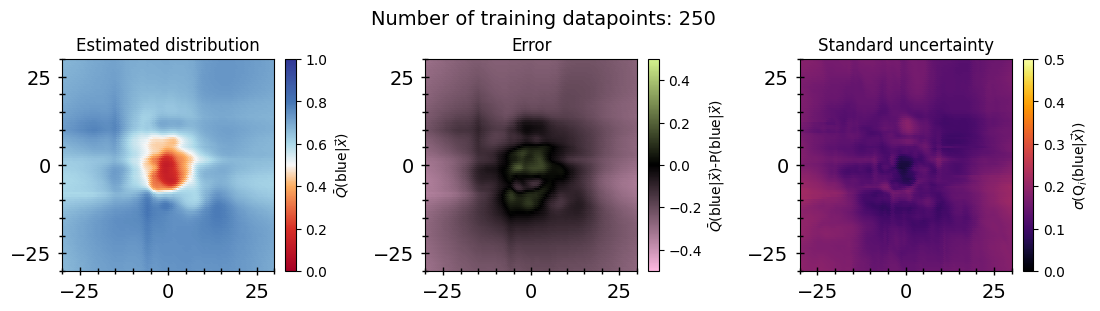

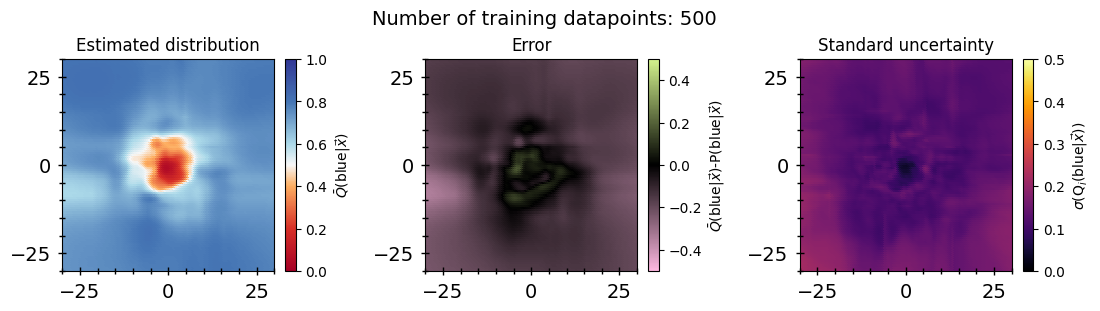

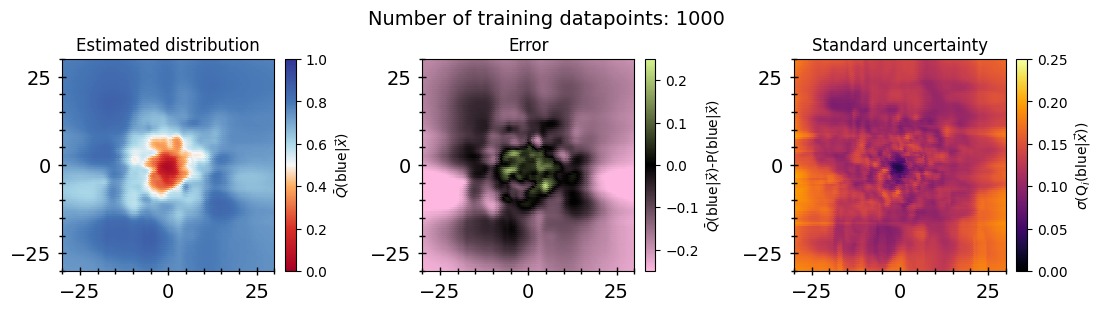

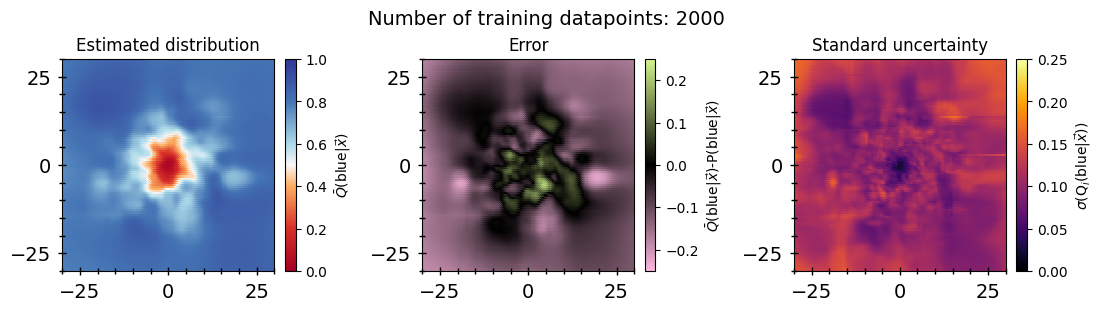

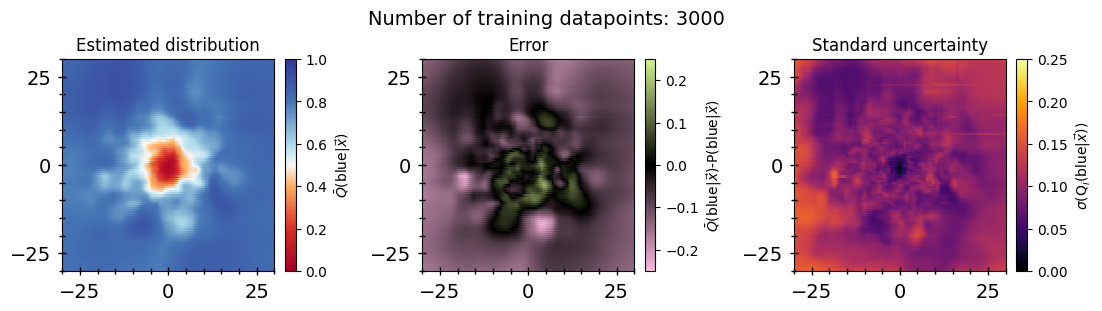

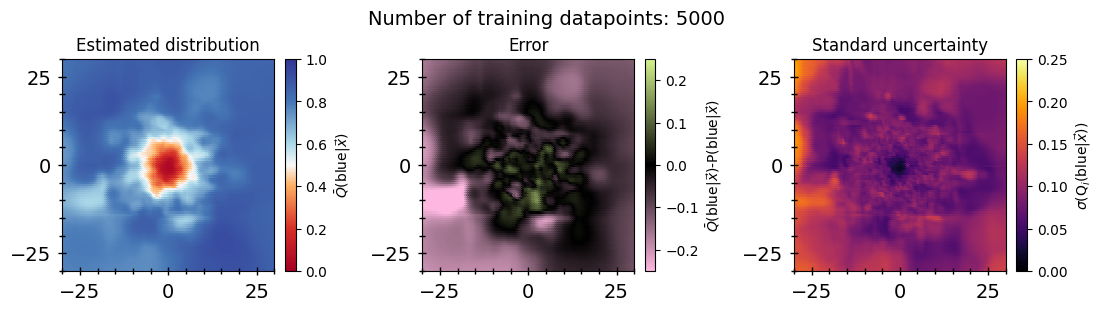

In [26]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, 
                 label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_dfs[i], grid_data, "Est_prob_blue", "p_c1_given_r", axs[1], r"Error", max_val = max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), fraction=0.050, pad=0.04, 
                 label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

    axs[2] = plot_std(grid_dfs[i], "Std_samples_blue", axs[2], "Standard uncertainty", grid=True, max_val = max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, 
                 label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    #fig.savefig(f"../fig/mixture_model_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)


### Results from inference

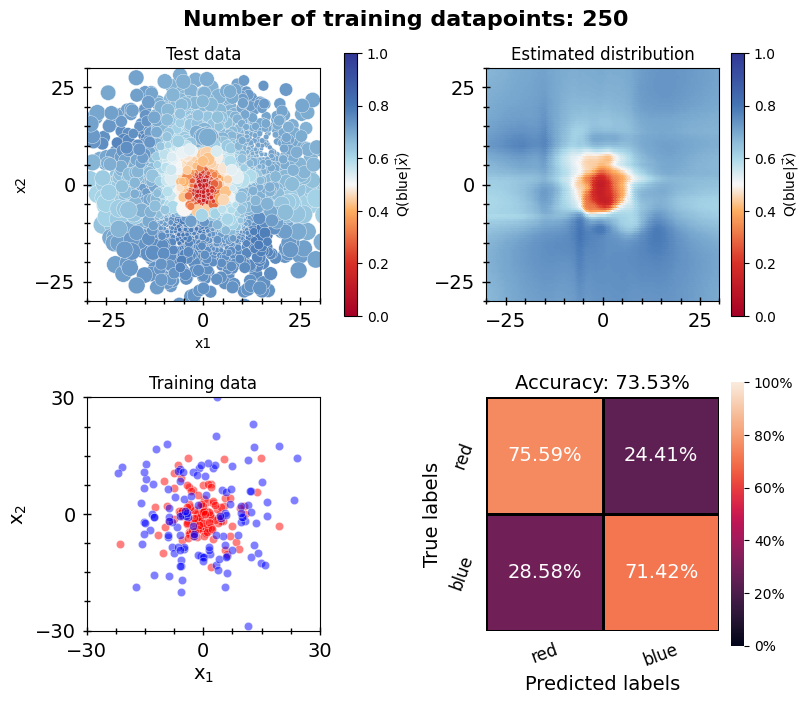

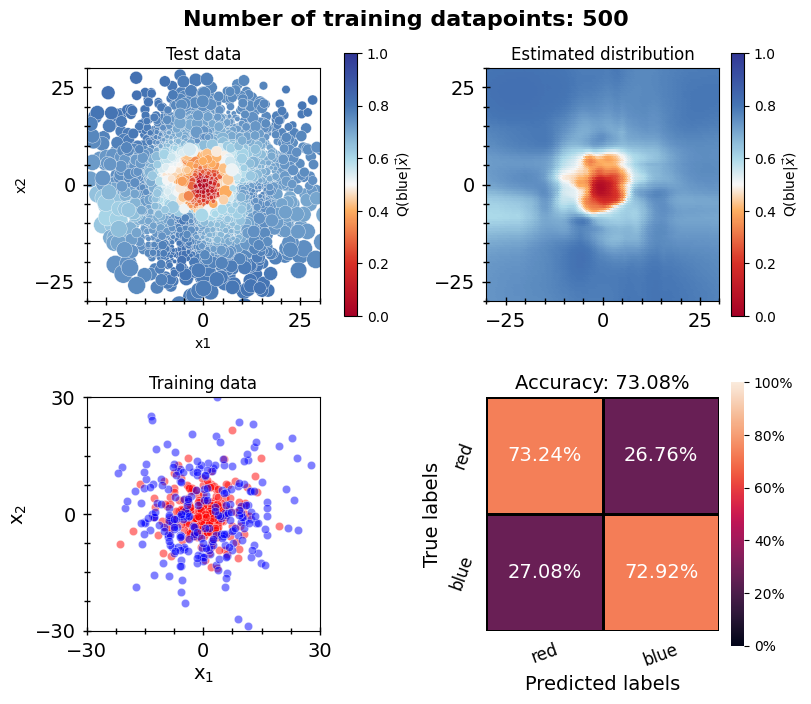

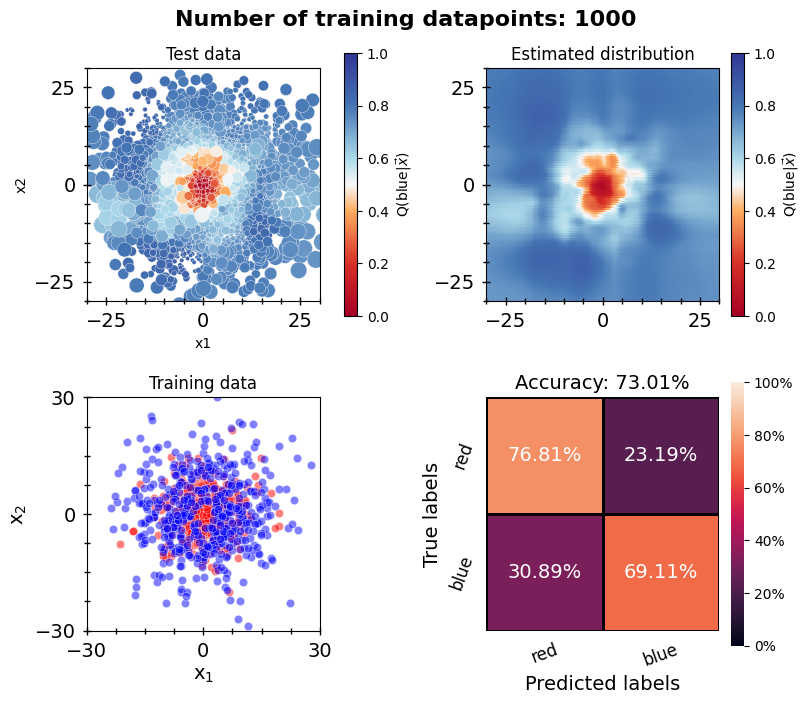

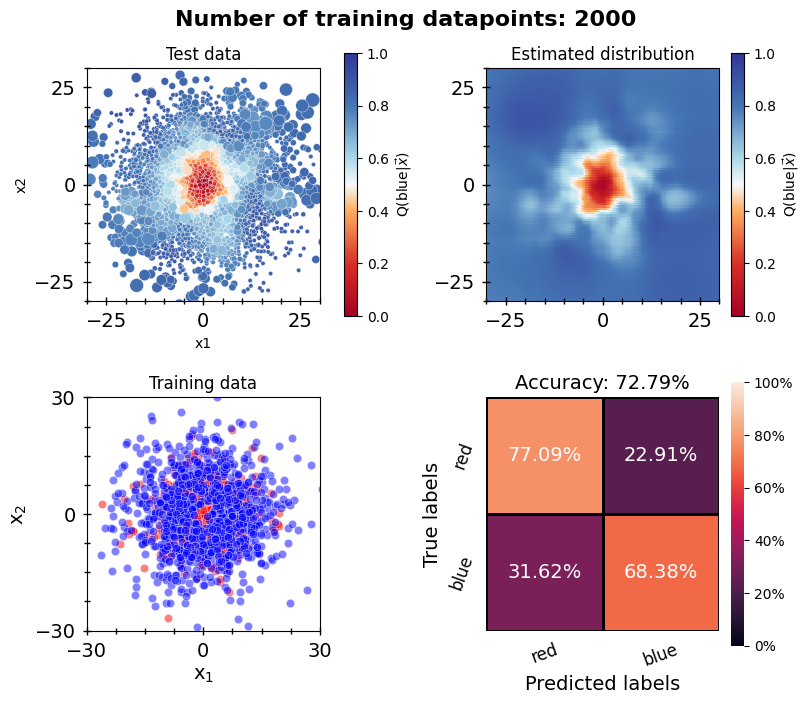

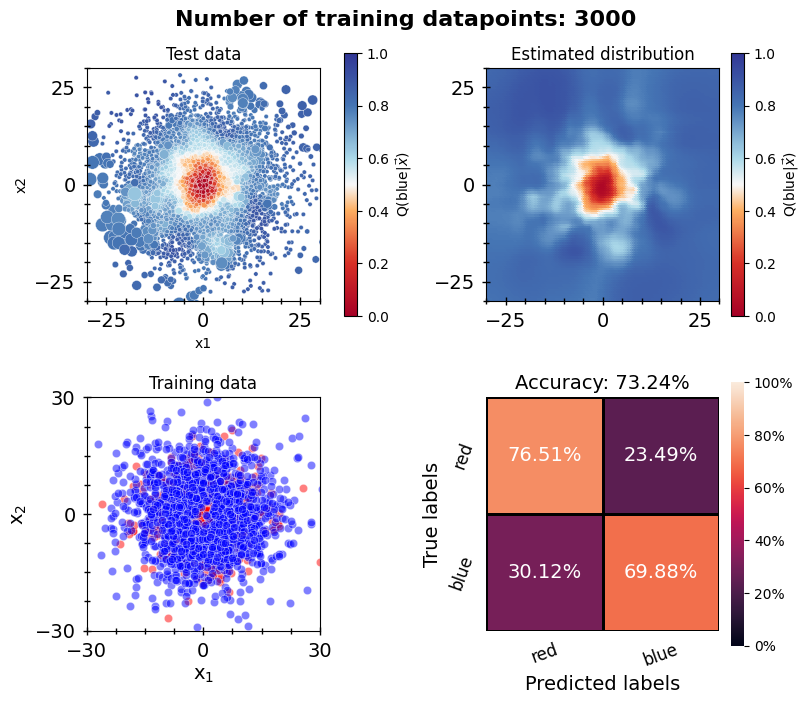

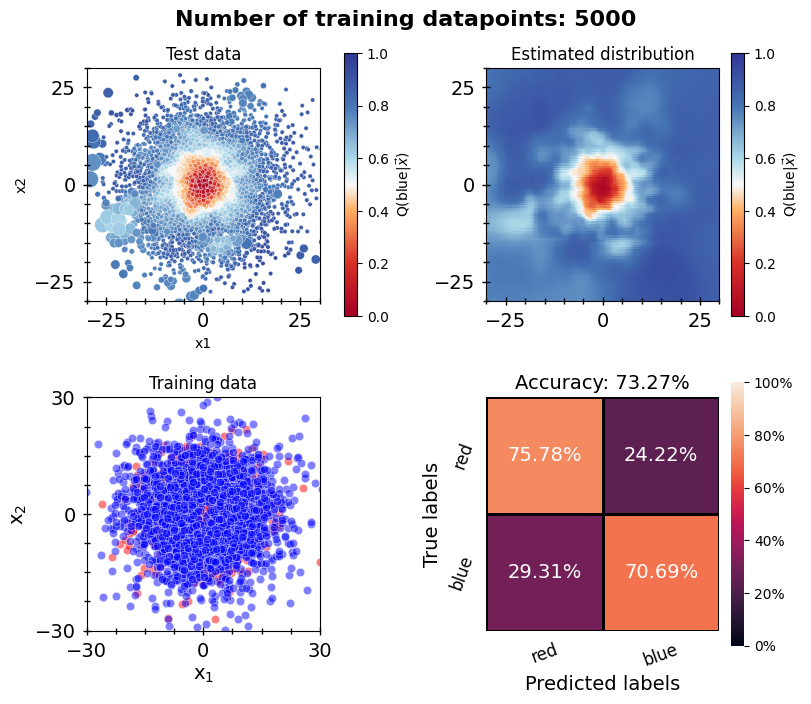

In [27]:

# Plot results

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
    
    #plot data
    axs[0][0] = plot_results(test_dfs[i], "Est_prob_blue", axs[0][0], "Test data", error_key="Std_samples_blue", rmax=grid_rmax)
    axs[0][1] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data", rmax=grid_rmax)
    axs[1][1] = plot_conf_matrix(test_dfs[i], "Truth_label", "Inferred_color", ["red", "blue"], axs[1][1])
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")
    #plt.savefig(f"../../fig/results/inferno/{testfile}_{trainfile}_n_{n_data[i]}")

#plt.show()
    

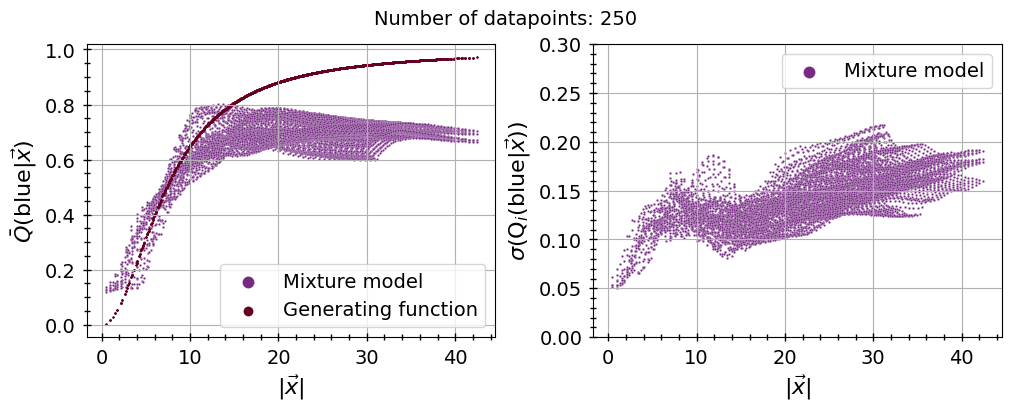

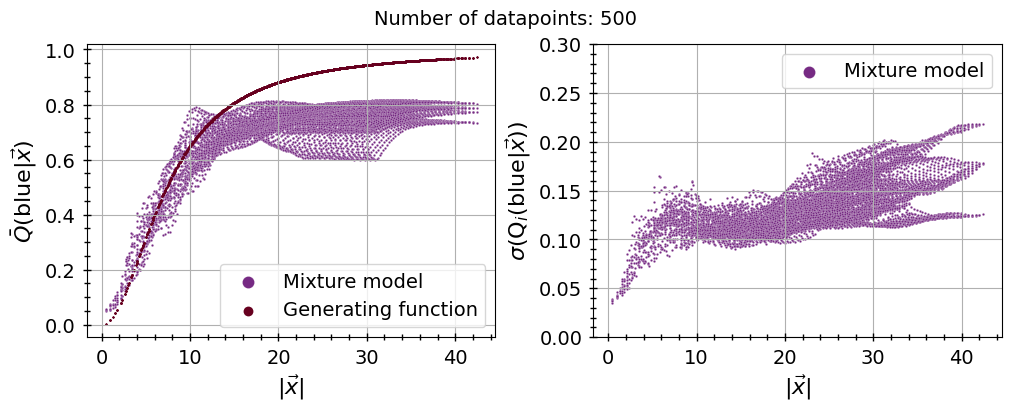

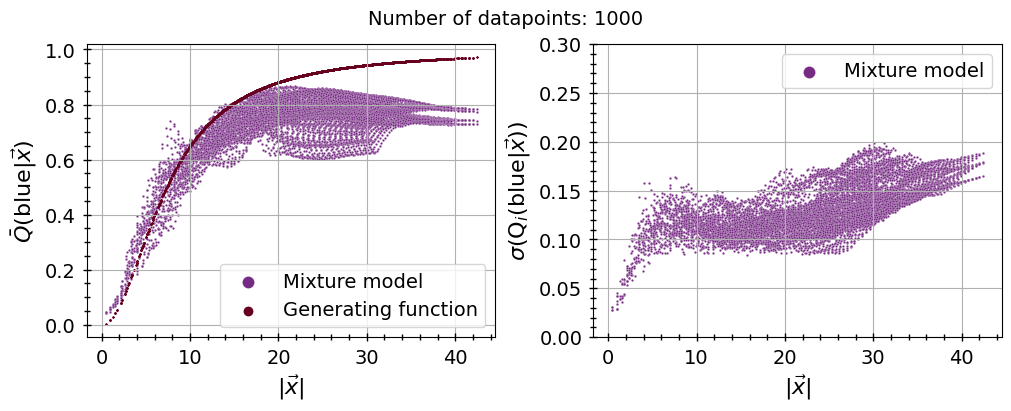

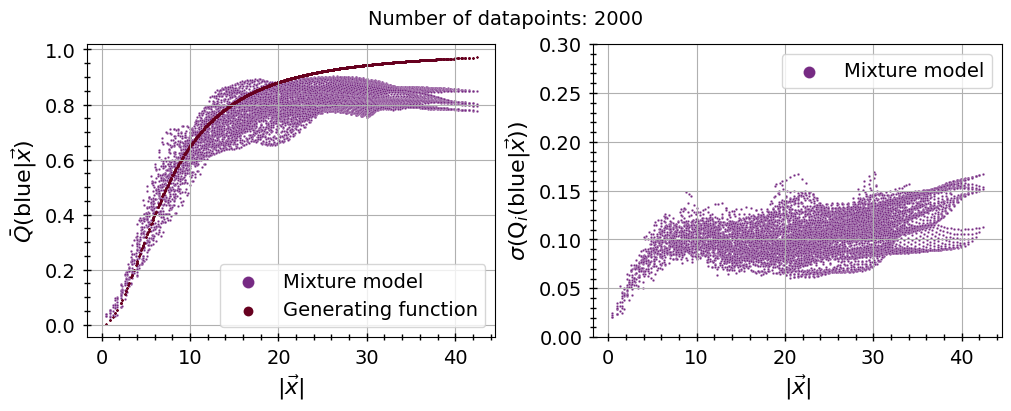

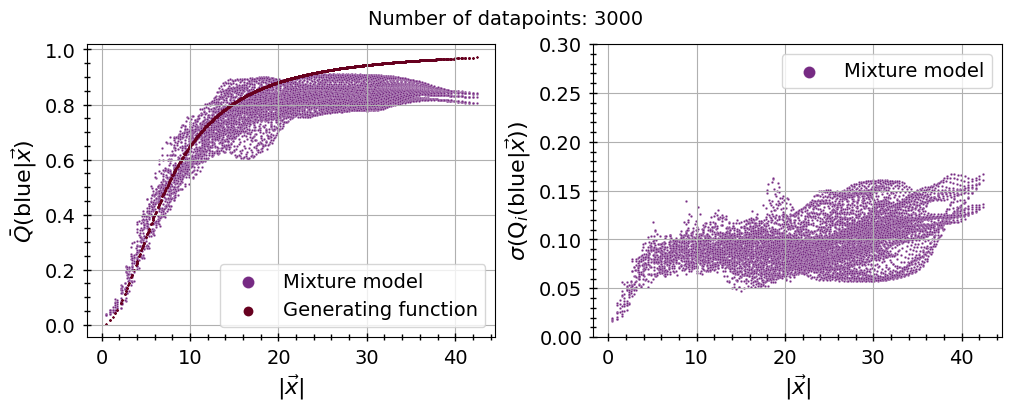

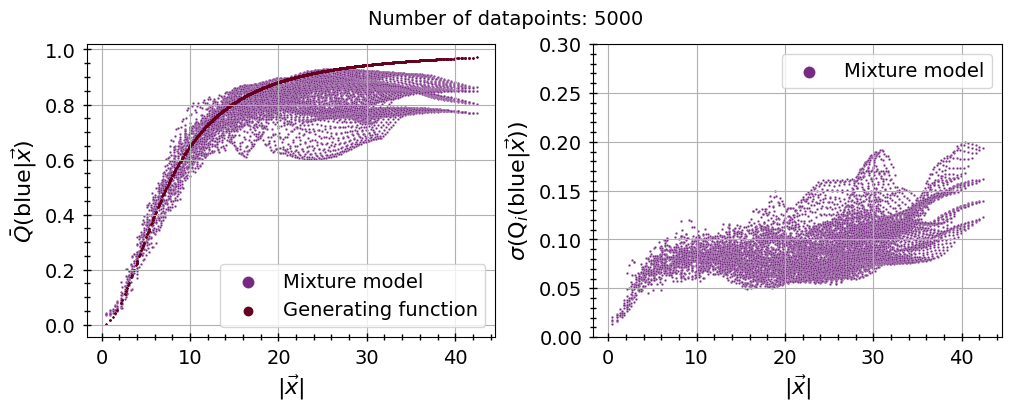

In [28]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs[i], x="r", y="Est_prob_blue", s=3, ax = axs[0], label="Mixture model", color="#762a83")
    #sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
    sn.scatterplot(grid_data, x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
    axs[0].set_ylabel(r"$\bar{Q}$(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r", y="Std_samples_blue", s=3, ax = axs[1], label="Mixture model", color="#762a83")
    axs[1].set_ylabel(r"$\sigma$(Q$_i$(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", fontsize=14)


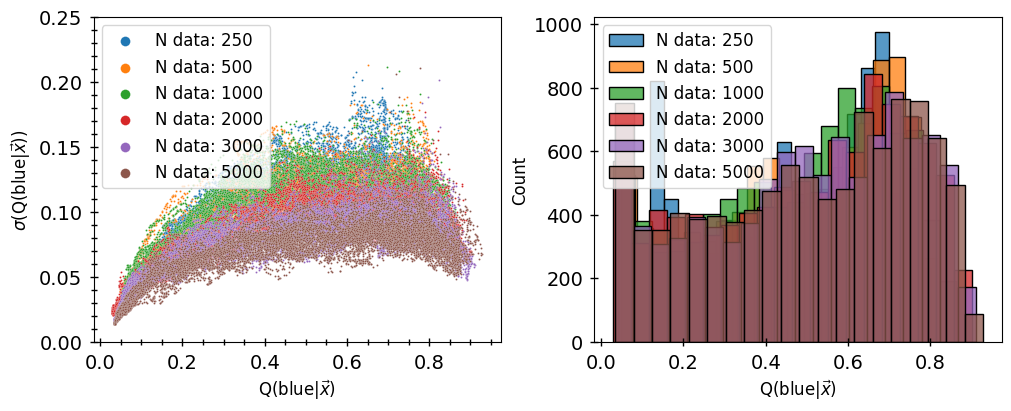

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_dfs[i], x="Est_prob_blue", y="Std_samples_blue", s=2, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_dfs[i], x="Est_prob_blue", label=f"N data: {n_data[i]}", ax = axs[1], edgecolor="black", linewidth=1, bins=20)
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)

    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

In [30]:
scores = calculate_metrics(test_dfs, grid_dfs, n_data, grid_data, test_data, 
                           "Inferred_class", "Est_prob_blue", "Std_samples_blue")
print(scores)

   N data       ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.735274  0.799832  0.066788  0.183656  0.114354  0.025673   
1     500  0.730873  0.804269  0.051688  0.141723  0.106140  0.025061   
2    1000  0.730073  0.805491  0.047697  0.129067  0.106356  0.025772   
3    2000  0.727873  0.804525  0.026780  0.084325  0.088245  0.023881   
4    3000  0.732373  0.805818  0.027145  0.075772  0.079751  0.021531   
5    5000  0.732673  0.808106  0.016955  0.073238  0.072055  0.021062   

   Mean KL-div test  Mean KL-div grid   LogLoss       ECE       MCE     RMSCE  
0          0.014848          0.027263  0.555631  0.067401  0.467793  0.074454  
1          0.008337          0.015789  0.544365  0.050266  0.107009  0.059523  
2          0.008120          0.014185  0.541909  0.044422  0.091781  0.052116  
3          0.005426          0.006618  0.536516  0.021670  0.059346  0.027438  
4          0.004574          0.005313  0.535555  0.026625  0.058261  0.031856  
5       

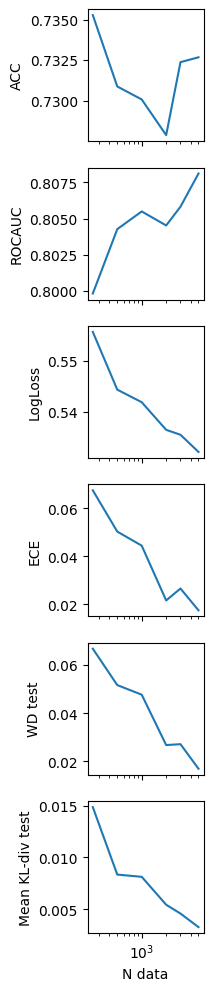

In [31]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(1.5, 12), sharex=True)
sn.lineplot(scores, x="N data", y="ACC", ax=axs[0])
sn.lineplot(scores, x="N data", y="ROCAUC", ax=axs[1])
sn.lineplot(scores, x="N data", y="LogLoss", ax=axs[2])
sn.lineplot(scores, x="N data", y="ECE", ax=axs[3])
sn.lineplot(scores, x="N data", y="WD test", ax=axs[4])
sn.lineplot(scores, x="N data", y="Mean KL-div test", ax=axs[5])
for ax in axs:
    ax.set_xscale("log")

### Calibration

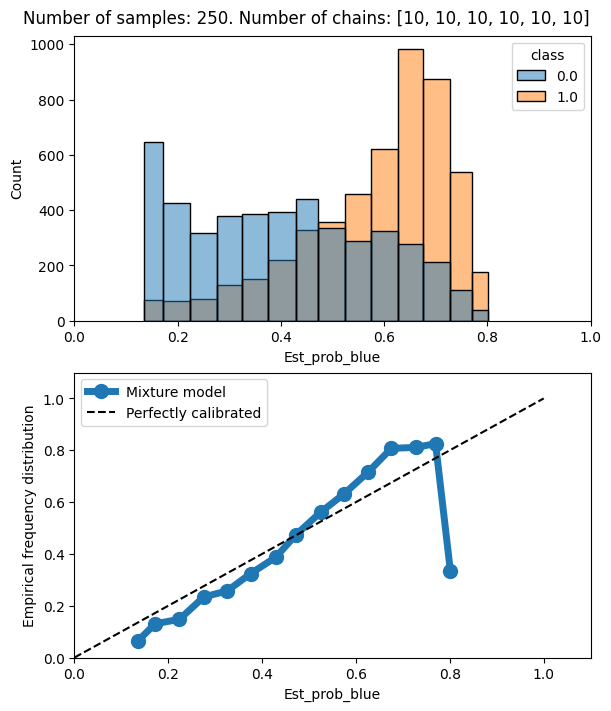

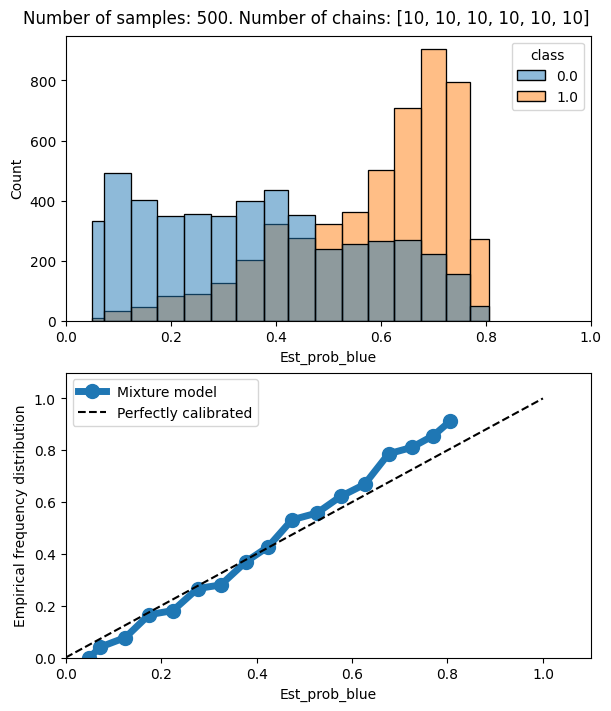

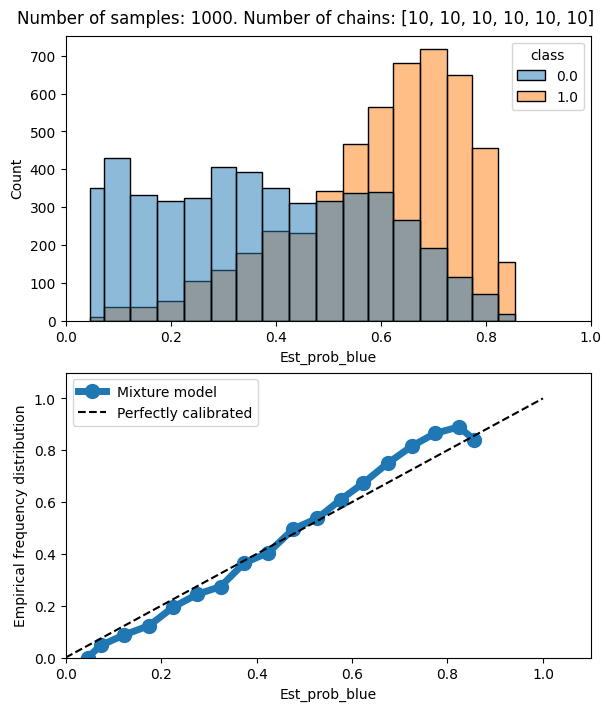

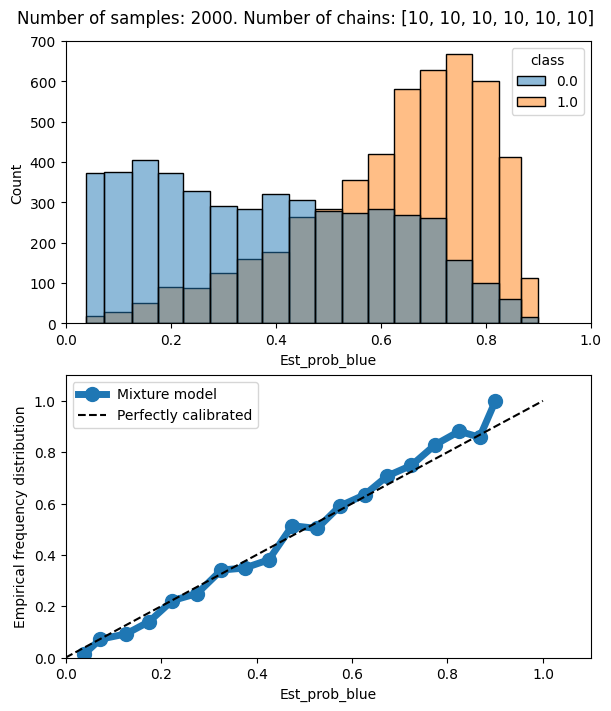

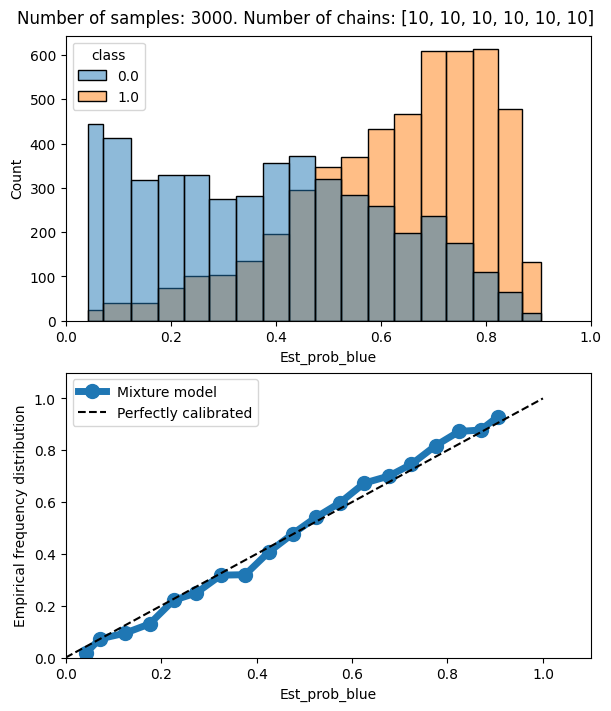

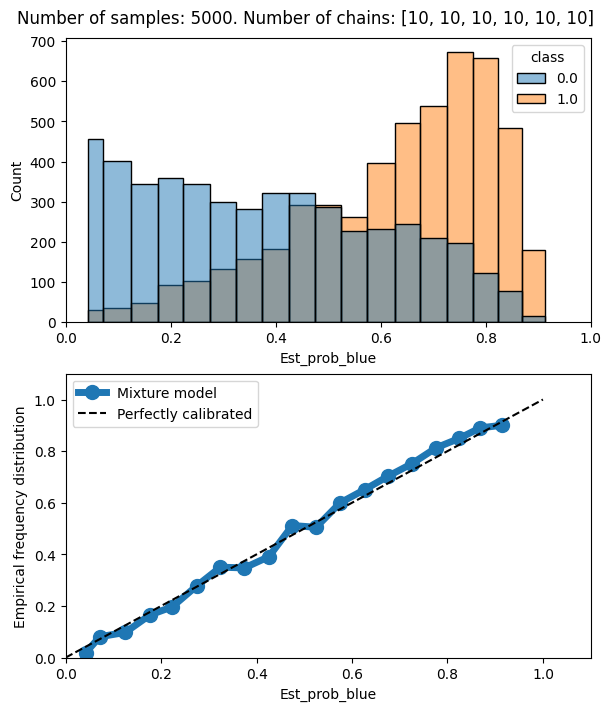

In [32]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

for i in range(n_plots):
    #Get confidence for red
    prob_cal, prob_pred = calibration_curve(test_dfs[i]["class"], test_dfs[i]["Est_prob_blue"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), layout="constrained")
    sn.histplot(test_dfs[i], x="Est_prob_blue", hue="class", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="Mixture model")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("Est_prob_blue")
    ax[1].set_ylabel("Empirical frequency distribution")
    ax[1].legend()
    fig.suptitle(f"Number of samples: {n_data[i]}. Number of chains: {n_chains}")